# Silverbox

Silverbox refers to one of the nonlinear system identification benchmarks on http://nonlinearbenchmark.org/#Silverbox. 
It is a simulation of a [Duffing oscillator](https://en.wikipedia.org/wiki/Duffing_equation), ocurring for instance in nonlinear spring pendulums.

State-space model description of the system:

$$\begin{align}
m \frac{d^2 x(t)}{dt^2} + c \frac{d x(t)}{dt} + a x(t) + b x^3(t) =&\ u(t) + w(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$

where
$$\begin{align}
m     =&\ \text{mass} \\
c     =&\ \text{damping} \\
a     =&\ \text{linear stiffness} \\
b     =&\ \text{nonlinear stiffness} \\
y(t)    =&\ \text{observation (displacement)} \\
x(t)    =&\ \text{state (displacement)} \\
u(t)    =&\ \text{force} \\
v(t)    =&\ \text{measurement noise} \\
w(t)    =&\ \text{process noise}
\end{align}$$

The process noise is a Wiener process, where the increment is Gaussian distributed $w(t) \sim \mathcal{N}(0, \tau^{-1}dt)$. The parameter $\tau$ represents the precision of the process. The measurement noise is also a Wiener process, $v(t) \sim \mathcal{N}(0, \xi^{-1}dt)$.

### Forecasting experiment

In this notebook, we will perform a forecasting experiment. At each point in time, the model will use the current estimates of parameters to generate predictions for the next 10 time-steps. We evaluate the model by averaging the prediction error as well as looking at how the prediction error decreases over time.

### Data

Let's first have a look at the data.

In [1]:
using Revise
using CSV
using DataFrames

In [2]:
using Plots
pyplot()
viz = true;

In [3]:
# Read data from CSV file
df = CSV.read("../data/SNLS80mV.csv", ignoreemptylines=true)
df = select(df, [:V1, :V2])

# Shorthand
input = df[:,1]
output = df[:,2]

# Time horizon
T = size(df, 1)

131072

In [4]:
# Clip data to constant amplitude regime
clip_ix = collect(40101:127500)
# clip_ix = 40575:49250
# clip_ix = 1:131072
input_ = input[clip_ix]
output_ = output[clip_ix]
T_ = length(clip_ix);

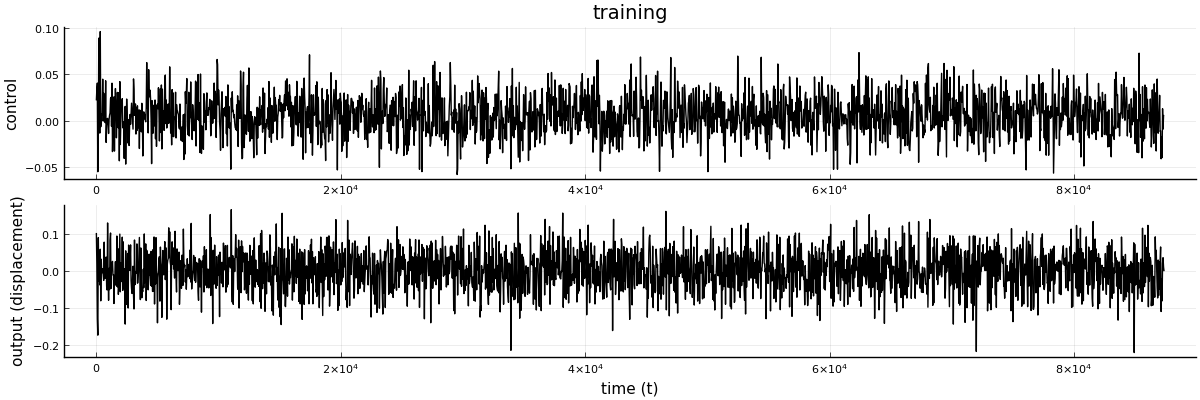

In [5]:
# Plot every n-th time-point to avoid figure size exploding
n = 40

if viz
    p1a = Plots.plot(1:n:T_, input_[1:n:end], color="black", label="", markersize=2, xlabel="", ylabel="control", size=(1200,400), title="training")    
    p1b = Plots.plot(1:n:T_, output_[1:n:end], color="black", label="", markersize=2, xlabel="time (t)", ylabel="output (displacement)", size=(1200,400))    
    p1 = plot(p1a, p1b, layout=(2,1))
#     Plots.savefig(p1, "viz/constant-amp-regime.png")
end

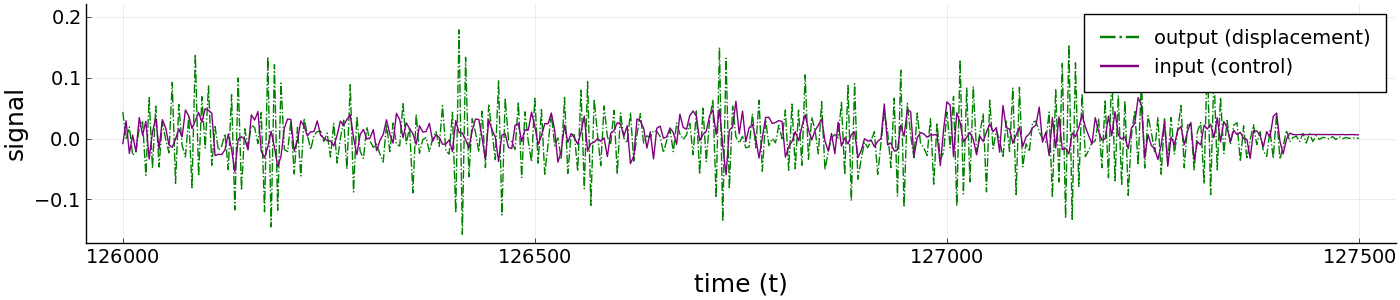

In [6]:
ss = 4
ix = 126000:ss:127500
p31 = Plots.plot(ix, output[ix], color="green", markersize=2, xlabel="time (t)", label="output (displacement)", linestyle=:dashdot)    
Plots.plot!(ix, input[ix], color="purple", markersize=2, xlabel="time (t)", label="input (control)", size=(1400,300), ylim=[-.16, .21], legend=:topright, tickfontsize=14, legendfontsize=14, ylabel="signal", guidefontsize=18)

In [7]:
Plots.savefig(p31, "viz/input-output_seq1.png")
Plots.savefig(p31, "viz/input-output_seq1.pdf")

## Solution steps

### 1. Discretize

I'm using a central difference for the second derivative and a forward difference for the first derivative. Let $w_t$ be a sample from $\mathcal{N}(0, \tau^{-1})$. The state transition can now be written as the following discrete-time system:

$$\begin{align}
m (x_{t+1} - 2x_{t} + x_{t-1}) + c (x_{t+1} - x_{t}) + a x_t + b x_t^3 =&\ u_t + w_t
\end{align}$$
Re-writing this as a function of $x_{t+1}$ yields:
$$\begin{align}
% (m + c) x_{t+1}&\ + (-2m - c + a) x_{t} + bx_t^3 + m x_{t-1} = u_t + w_t \\
x_{t+1}&\ = \frac{2m + c - a}{m + c} x_{t} + \frac{-b}{m + c}x_t^3 + \frac{-m}{m + c} x_{t-1} + \frac{1}{m + c} u_t + \frac{1}{m + c} w_t \, .
\end{align}$$

### 2. Substitute variables and reduce order

I can cast the above system into matrix form:

$$ \underbrace{\begin{bmatrix} x_{t+1} \\ x_{t} \end{bmatrix}}_{z_t} = \underbrace{\begin{bmatrix} 0 & 0 \\ 1 & 0 \end{bmatrix}}_{S} \underbrace{\begin{bmatrix} x_{t} \\ x_{t-1} \end{bmatrix}}_{z_{t-1}} + \underbrace{\begin{bmatrix} 1 \\ 0 \end{bmatrix}}_{e} g(z_{t-1}, \theta) + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \eta u_t + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \tilde{w}_t \, ,$$

where

$$\begin{align}
\theta_1 =&\ \frac{2m+c-a}{m+c} \\
\theta_2 =&\ \frac{-b}{m+c} \\
\theta_3 =&\ \frac{-m}{m+c} \\
\eta =&\ \frac{1}{m+c} \\
\gamma^{-1} =& \tau^{-1} \frac{1}{(m+c)^2} \, ,
\end{align}$$

and $g(z_{t-1}, \theta) = \theta_1 x_t + \theta_2 x_t^3 + \theta_3 x_{t-1}$ and $\tilde{w}_t \sim \mathcal{N}(0, \gamma^{-1})$. In total, I have five unknowns $m,c,a,b,\tau$ and five equations. I can invert the mapping between $\phi = (m, c, a, b, \tau)$ and $\psi = (\theta_1, \theta_2, \theta_3, \eta, \gamma)$ to recover MAP estimates for the physical parameters. Variable substitution allows for more freedom in choosing priors.

The system is now a nonlinear autoregressive process:

$$z_t = f(z_{t-1}, \theta, \eta, u_t) + \tilde{w}_t$$

where $f(z_{t-1}, \theta, \eta, u_t) = Sz_{t-1} + e g(z_{t-1}, \theta) + e \eta u_t$. Note that we need a two-dimensional state prior now (reminiscent of adding an initial condition on the velocity).

### 3. Convert to Gaussian probability

Integrating out $\tilde{w}_t$ and $v_t$ produces a Gaussian state transition node:

$$\begin{align}
z_t \sim&\ \mathcal{N}(f(z_{t-1}, \theta, \eta, u_t), V) \\
y_t \sim&\ \mathcal{N}(e^{\top} z_t, \xi^{-1}) \, ,
\end{align}$$

where $V = \begin{bmatrix} \gamma^{-1} & 0 \\ 0 & \epsilon \end{bmatrix}$ and $W = V^{-1} = \begin{bmatrix} \gamma & 0 \\ 0 & \epsilon^{-1} \end{bmatrix}$.

### 4. Approximating the nonlinearity

The nonlinearity is approximated using a first-order Taylor expansion. The work here revolves around working out the expectations for $g(x,\theta)$:

$$ g(x,\theta) = g(m_x, m_{\theta}) + J_{x}(m_x, m_{\theta})^{\top}(x - m_x) + J_{\theta}(m_x, m_{\theta})^{\top}(\theta - m_{\theta}) \, ,$$

where $J_x$ denotes the partial derivative of $g$ with respect to $x$ and $J_{\theta}$ w.r.t. $\theta$. Note that our current $g$ is linear in $\theta$ and you could argue that you don't need to approximate it. However, the first-order Taylor is exact in that case.

### 5. Choose priors

We know that mass $m$ and process precision $\gamma$ are strictly positive parameters and that the damping and stiffness coefficients can be both positive and negative. By examing the nonlinear transform $\psi = G(\phi)$, we realize that $\theta_1$, $\theta_2$, $\theta_3$ and $\eta$ can be both positive and negative, but $\gamma$ can only be positive. As such, we choose the following priors:

$$\begin{align}
\theta \sim&\ \text{Normal}(m^{0}_{\theta}, V^{0}_{\theta}) \\
\eta \sim&\ \text{Normal}(m^{0}_{\eta}, v^{0}_{\eta}) \\ 
\gamma \sim&\ \text{Gamma}(a^{0}_\gamma, b^{0}_\gamma) \, .
\end{align}$$

### 6. Recover physical variables from substituted ones

Since we have five equations and five unknowns, we can perfectly recover point estimates of the physical variables from substituted ones. However, we don't want point estimates, we want posteriors. 

If we approximate $\gamma$ with a log-Normal distribution and then map it to a Gaussian distribution (i.e. model $\tilde{\gamma} = \log(\gamma)$), we end up with a Gaussian distributed random vector $\psi = [\theta_1, \theta_2, \theta_3, \eta, \tilde{\gamma}]$. We can perform a Gaussian approximation of the inverse mapping $G^{-1}(\psi)$ using a first-order Taylor expansion:

$$\begin{align}
m_{\phi} \triangleq \mathbb{E}[G^{-1}(\psi)] =&\ G^{-1}(m_{\psi}) \\
V_{\phi} \triangleq \mathbb{V}[G^{-1}(\psi)] =&\ J_{\psi}(m_{\psi}) G^{-1}(m_{\psi}) J_{\psi}(m_{\psi})^{\top} \, ,
\end{align}$$

The inverse mapping has the form:

$$\begin{align} 
m =&\ \frac{-\theta_3}{\eta} \\
c =&\ \frac{1+\theta_3}{\eta} \\
a =&\ \frac{(1-\theta_1 - \theta_3)}{\eta} \\
b =&\ \frac{-\theta_2}{\eta} \\
\tau =&\ \tilde{\gamma} \eta^2 \, .
\end{align}$$

The Jacobian can be obtained automatically using Julia packages such as ForwardDiff.jl or Zygote.jl.

## Implementation

We implemented the above solution with ForneyLab and a custom node called "NLARX". It contains a Nonlinear Latent Autoregressive model with eXogenous input (hence NLARX), that will model the state transition.

In [8]:
using LinearAlgebra
using ForneyLab
using ForneyLab: unsafeMean, unsafeCov, unsafeVar, unsafePrecision
using ProgressMeter

include("../NLARX-node/NLARX.jl")
using .NLARX

In [9]:
using Zygote

function Jacobian(F, x)
    y = F(x)
    n = length(y)
    m = length(x)
    T = eltype(y)
    J = Array{T, 2}(undef, n, m)
    for i in 1:n
        J[i, :] .= gradient(x -> F(x)[i], x)[1]
    end
    return J
end;

In [10]:
# System identification graph
graph1 = FactorGraph()

# Static parameters
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(3,)), placeholder(:w_θ, dims=(3,3)))
@RV η ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))
@RV γ ~ Gamma(placeholder(:a_γ), placeholder(:b_γ))
@RV ξ ~ Gamma(placeholder(:a_ξ), placeholder(:b_ξ))

# Nonlinearity
function g(arg::Array{Float64,1}; num_coeffs::Int64=3)
    θ = arg[1:num_coeffs]
    x = arg[num_coeffs+1:end]
    return θ[1]*x[1] + θ[2]*x[1]^3 + θ[3]*x[2]
end

# State prior
@RV z_tmin1 ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_tmin1)

# Autoregressive node
@RV z_t ~ NLatentAutoregressiveX(θ, z_tmin1, η, placeholder(:u_t), γ, g=g, id=:z_t)

# Specify likelihood
@RV y_t ~ GaussianMeanPrecision(dot([1. , 0.], z_t), ξ, id=:y_t)

# Placeholder for observation
placeholder(y_t, :y_t)

# Draw time-slice subgraph
ForneyLab.draw(graph1)

# Inference algorithm
q1 = PosteriorFactorization(z_t, z_tmin1, θ, η, γ, ξ, ids=[:z_t, :z_tmin1, :θ, :η, :γ, :ξ])
algo1 = variationalAlgorithm(q1, free_energy=false)
source_code1 = algorithmSourceCode(algo1, free_energy=false)
eval(Meta.parse(source_code1));
# println(source_code)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 12149057127916279794 -->
 
 12149057127916279794 
 
 clamp_1 
 
<!-- 362950912041855768 -->
 
 362950912041855768 
 
 𝒩 
 y_t 
 
<!-- 3473351390222219546 -->
 
 3473351390222219546 
 
 Gam 
 gamma_2 
 
<!-- 362950912041855768--3473351390222219546 -->
 
 362950912041855768--3473351390222219546 
 
 ξ 
 1 out 
 3 w 
 
<!-- 1535668320890606454 -->
 
 1535668320890606454 
 
 dot 
 dotproduct_1 
 
<!-- 362950912041855768--1535668320890606454 -->
 
 362950912041855768--1535668320890606454 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 3445954451529701208 -->
 
 3445954451529701208 
 
 placeholder_u_t 
 
<!-- 8849296770834063471 -->
 
 8849296770834063471 
 
 placeholder_w_z 
 
<!-- 15674038223987427196 -->
 
 15674038223987427196 
 
 placeholder_w_θ 
 
<!-- 3121354079067007237 -->
 
 3121354079067007237 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 3121354079067007237--15674038223987427196 -->
 
 3121354079067007237--15674038223987427196 
 
 w_θ 
 1 out 
 3 w 
 
<!-- 15425406475647720596 -->
 
 15425406475647720596 
 
 placeholder_m_θ 
 
<!-- 3121354079067007237--15425406475647720596 -->
 
 3121354079067007237--15425406475647720596 
 
 m_θ 
 1 out 
 2 m 
 
<!-- 17454097182235271730 -->
 
 17454097182235271730 
 
 Gam 
 gamma_1 
 
<!-- 7115292977994644825 -->
 
 7115292977994644825 
 
 placeholder_b_γ 
 
<!-- 17454097182235271730--7115292977994644825 -->
 
 17454097182235271730--7115292977994644825 
 
 b_γ 
 1 out 
 3 b 
 
<!-- 13028252730782763010 -->
 
 13028252730782763010 
 
 placeholder_a_γ 
 
<!-- 17454097182235271730--13028252730782763010 -->
 
 17454097182235271730--13028252730782763010 
 
 a_γ 
 1 out 
 2 a 
 
<!-- 17206440437020718143 -->
 
 17206440437020718143 
 
 placeholder_a_ξ 
 
<!-- 3473351390222219546--17206440437020718143 -->
 
 3473351390222219546--17206440437020718143 
 
 a_ξ 
 1 out 
 2 a 
 
<!-- 4383931586645783212 -->
 
 4383931586645783212 
 
 placeholder_b_ξ 
 
<!-- 3473351390222219546--4383931586645783212 -->
 
 3473351390222219546--4383931586645783212 
 
 b_ξ 
 1 out 
 3 b 
 
<!-- 14231419791331848368 -->
 
 14231419791331848368 
 
 placeholder_m_η 
 
<!-- 7305589541589865048 -->
 
 7305589541589865048 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 7305589541589865048--14231419791331848368 -->
 
 7305589541589865048--14231419791331848368 
 
 m_η 
 1 out 
 2 m 
 
<!-- 16672222758011494523 -->
 
 16672222758011494523 
 
 placeholder_w_η 
 
<!-- 7305589541589865048--16672222758011494523 -->
 
 7305589541589865048--16672222758011494523 
 
 w_η 
 1 out 
 3 w 
 
<!-- 9840934348964807802 -->
 
 9840934348964807802 
 
 placeholder_y_t 
 
<!-- 9840934348964807802--362950912041855768 -->
 
 9840934348964807802--362950912041855768 
 
 y_t 
 1 out 
 1 out 
 
<!-- 1183274589129340783 -->
 
 1183274589129340783 
 
 placeholder_m_z 
 
<!-- 12539895112106058213 -->
 
 12539895112106058213 
 
 𝒩 
 z_tmin1 
 
<!-- 12539895112106058213--8849296770834063471 -->
 
 12539895112106058213--8849296770834063471 
 
 w_z 
 1 out 
 3 w 
 
<!-- 12539895112106058213--1183274589129340783 -->
 
 12539895112106058213--1183274589129340783 
 
 m_z 
 1 out 
 2 m 
 
<!-- 16230170316257062629 -->
 
 16230170316257062629 
 
 NLARX 
 z_t 
 
<!-- 16230170316257062629--3445954451529701208 -->
 
 16230170316257062629--3445954451529701208 
 
 u_t 
 1 out 
 5 u 
 
<!-- 16230170316257062629--3121354079067007237 -->
 
 16230170316257062629--3121354079067007237 
 
 θ 
 1 out 
 3 θ 
 
<!-- 16230170316257062629--17454097182235271730 -->
 
 16230170316257062629--17454097182235271730 
 
 γ 
 1 out 
 6 γ 
 
<!-- 16230170316257062629--7305589541589865048 -->
 
 16230170316257062629--7305589541589865048 
 
 η 
 1 out 
 4 η 
 
<!-- 16230170316257062629--12539895112106058213 -->
 
 16230170316257062629--12539895112106058213 
 
 z_t

In [11]:
# Forecasting graph
graph2 = FactorGraph()

# State prior
@RV z_pred_tmin1 ~ GaussianMeanPrecision(placeholder(:m_z_pred, dims=(2,)), placeholder(:w_z_pred, dims=(2, 2)), id=:z_pred_tmin1)

# Autoregressive node
@RV z_pred_t ~ NLatentAutoregressiveX(placeholder(:θ, dims=(3,)), z_pred_tmin1, placeholder(:η), placeholder(:u_t), placeholder(:γ), g=g, id=:z_pred_t)

# Draw time-slice subgraph
ForneyLab.draw(graph2)

# Inference algorithm
q2 = PosteriorFactorization(z_pred_t, z_pred_tmin1, ids=[:z_pred_t, :z_pred_tmin1])
algo2 = variationalAlgorithm(q2, free_energy=false)
source_code2 = algorithmSourceCode(algo2, free_energy=false)
eval(Meta.parse(source_code2));
# println(source_code)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 17976045705243319947 -->
 
 17976045705243319947 
 
 𝒩 
 z_pred_tmin1 
 
<!-- 14329315214868564640 -->
 
 14329315214868564640 
 
 placeholder_m_z_pred 
 
<!-- 17976045705243319947--14329315214868564640 -->
 
 17976045705243319947--14329315214868564640 
 
 m_z_pred 
 1 out 
 2 m 
 
<!-- 10695000317075387411 -->
 
 10695000317075387411 
 
 placeholder_w_z_pred 
 
<!-- 17976045705243319947--10695000317075387411 -->
 
 17976045705243319947--10695000317075387411 
 
 w_z_pred 
 1 out 
 3 w 
 
<!-- 1865821684501080693 -->
 
 1865821684501080693 
 
 placeholder_γ 
 
<!-- 17065569716463765849 -->
 
 17065569716463765849 
 
 NLARX 
 z_pred_t 
 
<!-- 17065569716463765849--17976045705243319947 -->
 
 17065569716463765849--17976045705243319947 
 
 z_pred_tmin1 
 1 out 
 2 x 
 
<!-- 17065569716463765849--1865821684501080693 -->
 
 17065569716463765849--1865821684501080693 
 
 γ 
 1 out 
 6 γ 
 
<!-- 5402616420625469878 -->
 
 5402616420625469878 
 
 placeholder_θ 
 
<!-- 17065569716463765849--5402616420625469878 -->
 
 17065569716463765849--5402616420625469878 
 
 θ 
 1 out 
 3 θ 
 
<!-- 7905852502976591358 -->
 
 7905852502976591358 
 
 placeholder_u_t 
 
<!-- 17065569716463765849--7905852502976591358 -->
 
 17065569716463765849--7905852502976591358 
 
 u_t 
 1 out 
 5 u 
 
<!-- 8982209447164992782 -->
 
 8982209447164992782 
 
 placeholder_η 
 
<!-- 17065569716463765849--8982209447164992782 -->
 
 17065569716463765849--8982209447164992782 
 
 η 
 1 out 
 4 η 
 
<!-- 181420383121934531582 -->
 
 181420383121934531582 
 
<!-- 181420383121934531582--17065569716463765849 -->
 
 181420383121934531582--17065569716463765849 
 
 z_pred_t 
 1 y

### Infer parameters and forecast several steps ahead

In [12]:
# Number of steps ahead
TT = 10

# Inference parameters
num_iterations = 10

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_z = (zeros(2,T_ - TT), repeat(.1 .*float(eye(2)), outer=(1,1,T_ - TT)))
params_θ = (ones(3,T_ - TT), repeat(.1 .*float(eye(3)), outer=(1,1,T_ - TT)))
params_η = (ones(1,T_ - TT), .1*ones(1,T_ - TT))
params_γ = (1e3*ones(1,T_ - TT), 1e1*ones(1,T_ - TT))
params_ξ = (1e8*ones(1,T_ - TT), 1e3*ones(1,T_ - TT))

# Initialize coefficient vector arrays
params_ϕ = (zeros(5,T_ - TT), zeros(5,5,T_ - TT))
params_ψ = (zeros(5,T_ - TT), zeros(5,5,T_ - TT))

# Initialize future state arrays
params_zpred_nar = (zeros(2, T_ - TT, TT+1), repeat(.1 .*float(eye(2)), outer=(1,1,T_ - TT, TT+1)))
pred_diff_nar = zeros(T_ - TT, TT)
pred_pwerr_nar = zeros(T_ - TT, TT)

# Transformations between physical and substituted variables: ψ = G(ϕ) => ϕ = G_inv(ψ)
G(ϕ) = [(2*ϕ[1] + ϕ[2] - ϕ[3])/(ϕ[1]+ϕ[2]), -ϕ[4]/(ϕ[1]+ϕ[2]), -ϕ[1]/(ϕ[1]+ϕ[2]), 1/(ϕ[1]+ϕ[2]), ϕ[5]*(ϕ[1]+ϕ[2])^2]
G_inv(ψ) = [-ψ[3]/ψ[4], (1+ψ[3])/ψ[4], (1 - ψ[1] - ψ[3])/ψ[4], -ψ[2]/ψ[4], ψ[5]*ψ[4]^2]

# Start progress bar
p = Progress(T_ - TT, 1, "At time ")

# Perform inference at each time-step
for t = 2:(T_ - TT)

    # Update progress bar
    update!(p, t)
    
    "Filtering"

    # Initialize marginals
    marginals[:z_tmin1] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_z[1][:,t-1], w=params_z[2][:,:,t-1])
    marginals[:z_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_z[1][:,t-1], w=params_z[2][:,:,t-1])
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,t-1], w=params_θ[2][:,:,t-1])
    marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_η[1][1,t-1], w=params_η[2][1,t-1])
    marginals[:γ] = ProbabilityDistribution(Univariate, Gamma, a=params_γ[1][1,t-1], b=params_γ[2][1,t-1])
    marginals[:ξ] = ProbabilityDistribution(Univariate, Gamma, a=params_ξ[1][1,t-1], b=params_ξ[2][1,t-1])
    
    data = Dict(:y_t => output_[t],
                :u_t => input_[t],
                :m_z => params_z[1][:,t-1],
                :w_z => params_z[2][:,:,t-1],
                :m_θ => params_θ[1][:,t-1],
                :w_θ => params_θ[2][:,:,t-1],
                :m_η => params_η[1][1,t-1],
                :w_η => params_η[2][1,t-1],
                :a_γ => params_γ[1][1,t-1],
                :b_γ => params_γ[2][1,t-1],
                :a_ξ => params_ξ[1][1,t-1],
                :b_ξ => params_ξ[2][1,t-1])

    # Iterate variational parameter updates
    for i = 1:num_iterations

        stepz_t!(data, marginals)
        stepθ!(data, marginals)
        stepη!(data, marginals)
        stepγ!(data, marginals)
        stepξ!(data, marginals)
#         stepz_tmin1!(data, marginals)
    
    end

    # Store current parameterizations of marginals
    params_z[1][:,t] = unsafeMean(marginals[:z_t])
    params_z[2][:,:,t] = marginals[:z_t].params[:w]
    params_θ[1][:,t] = unsafeMean(marginals[:θ])
    params_θ[2][:,:,t] = marginals[:θ].params[:w]
    params_η[1][1,t] = unsafeMean(marginals[:η])
    params_η[2][1,t] = marginals[:η].params[:w]
    params_γ[1][1,t] = marginals[:γ].params[:a]
    params_γ[2][1,t] = marginals[:γ].params[:b]
    params_ξ[1][1,t] = marginals[:ξ].params[:a]
    params_ξ[2][1,t] = marginals[:ξ].params[:b]
    
    "Map substituted to physical variables via first-order Taylor"
    
    # Approximate gamma with log-normal via moment-matching
    Eγ = unsafeMean(marginals[:γ])
    Vγ = unsafeVar(marginals[:γ])
    m_γ = log(Eγ^2/sqrt(Vγ + Eγ^2))
    v_γ = log(Vγ/Eγ^2 + 1)

    # Construct vector of parameter estimates ψ
    m_ψ = [unsafeMean(marginals[:θ])[1], unsafeMean(marginals[:θ])[2], unsafeMean(marginals[:θ])[3], unsafeMean(marginals[:η])[1], m_γ]
    V_ψ = [unsafeCov(marginals[:θ]) zeros(3,2); zeros(2,3) [unsafeCov(marginals[:η])[1,1] 0;0 v_γ]]
    
    # Store psi
    params_ψ[1][:,t] = m_ψ
    params_ψ[2][:,:,t] = V_ψ
    
    # Compute Jacobian of transformation 
    J_ψ = Jacobian(G_inv, m_ψ)
    
    # Compute moments of transformed Gaussian using first-order Taylor approx
    m_ϕ = G_inv(m_ψ)
    V_ϕ = J_ψ*V_ψ*J_ψ'
    
    # Store phi
    params_ϕ[1][:,t] = m_ϕ
    params_ϕ[2][:,:,t] = V_ϕ
    
    "Forecast several steps ahead"
    
    if T_ > 2
    
        params_zpred_nar[1][:,t,1] = params_z[1][:,t]
        params_zpred_nar[2][:,:,t,1] = params_z[2][:,:,t]

        for tt = 1:TT

            # Initialize marginals
            marginals[:z_pred_tmin1] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_zpred_nar[1][:,t,tt], w=params_zpred_nar[2][:,:,t,tt])
            marginals[:z_pred_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_zpred_nar[1][:,t,tt], w=params_zpred_nar[2][:,:,t,tt])

            data = Dict(:u_t => input_[t+tt],
                        :m_z_pred => params_zpred_nar[1][:,t,tt],
                        :w_z_pred => params_zpred_nar[2][:,:,t,tt],
                        :θ => params_θ[1][:,t],
                        :η => params_η[1][t],
                        :γ => params_γ[1][t]/params_γ[2][t])

            # Iterate variational parameter updates
            for i = 1:num_iterations
                stepz_pred_t!(data, marginals)
                stepz_pred_tmin1!(data, marginals)
            end

            # Store current parameterizations of marginals
            params_zpred_nar[1][:,t,tt+1] = unsafeMean(marginals[:z_pred_t])
            params_zpred_nar[2][:,:,t,tt+1] = marginals[:z_pred_t].params[:w]

        end

        # Evaluate prediction error for forecast
        pred_diff_nar[t,:] = (params_zpred_nar[1][1,t,2:end] .- output_[t+1:t+TT])
        pred_pwerr_nar[t,:] = params_zpred_nar[2][1,1,t,2:end].*(params_zpred_nar[1][1,t,2:end] .- output_[t+1:t+TT]).^2

    end
end

At time 100%|███████████████████████████████████████████| Time: 0:10:4639m


### Visualize results

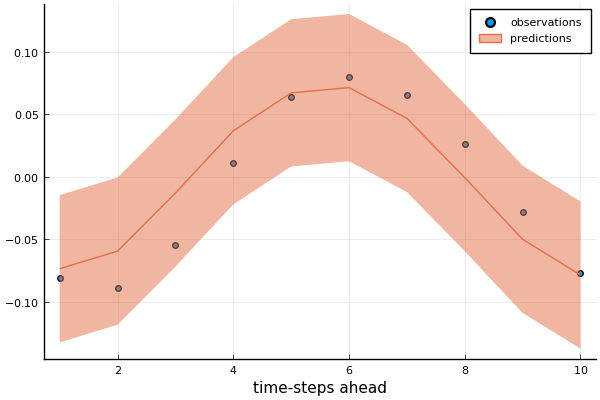

In [13]:
# Pick a time-point and visualize forecasting
t = 87200

# Mean and std dev of predictions
zpred_nar_mean = params_zpred_nar[1][1,t,2:TT+1]
zpred_nar_std = sqrt.(inv.(params_zpred_nar[2][1,1,t,2:TT+1])) 


scatter(output_[t+1:t+TT], label="observations", xlabel="time-steps ahead")
plot!(zpred_nar_mean, ribbon=[zpred_nar_std, zpred_nar_std], label="predictions")

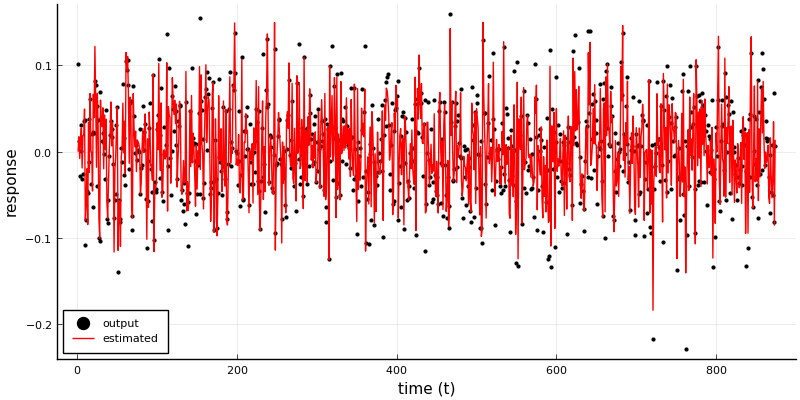

In [14]:
# Pick a number of steps ahead
tt = 9

# Extract mean of state marginals
estimated_states_nar = params_zpred_nar[1][1,:,1+tt]

# Plot every n-th time-point to avoid figure size exploding
n = 100

p23 = Plots.scatter(output_[1:n:end], color="black", label="output", markersize=2, size=(800,400), xlabel="time (t)", ylabel="response", legend=:bottomleft)
Plots.plot!(estimated_states_nar[1:n:end], color="red", linewidth=1, label="estimated")

In [15]:
Plots.savefig(p23, "viz/forecasted-states-nlarx_"*string(tt)*"stepahead.png")

## Baselines - linear

We can ignore the nonlinear component. 

TODO: update NLARX node

In [16]:
# System identification graph
graph3 = FactorGraph()

# Static parameters
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(2,)), placeholder(:w_θ, dims=(2,2)))
@RV η ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))
@RV γ ~ Gamma(placeholder(:a_γ), placeholder(:b_γ))
@RV ξ ~ Gamma(placeholder(:a_ξ), placeholder(:b_ξ))

# Nonlinearity
function g(arg::Array{Float64,1}; num_coeffs::Int64=2)
    θ = arg[1:num_coeffs]
    x = arg[num_coeffs+1:end]
    return θ[1]*x[1] + θ[2]*x[2]
end

# State prior
@RV z_tmin1 ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_tmin1)

# Autoregressive node
@RV z_t ~ NLatentAutoregressiveX(θ, z_tmin1, η, placeholder(:u_t), γ, g=g, id=:z_t)

# Specify likelihood
@RV y_t ~ GaussianMeanPrecision(dot([1. , 0.], z_t), ξ, id=:y_t)

# Placeholder for observation
placeholder(y_t, :y_t)

# Draw time-slice subgraph
ForneyLab.draw(graph1)

# Inference algorithm
q1 = PosteriorFactorization(z_t, z_tmin1, θ, η, γ, ξ, ids=[:z_t, :z_tmin1, :θ, :η, :γ, :ξ])
algo1 = variationalAlgorithm(q1, free_energy=false)
source_code1 = algorithmSourceCode(algo1, free_energy=false)
eval(Meta.parse(source_code1));
# println(source_code)

# Forecasting graph
graph4= FactorGraph()

# State prior
@RV z_pred_tmin1 ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_tmin1)

# Autoregressive node
@RV z_pred_t ~ NLatentAutoregressiveX(placeholder(:θ, dims=(2,)), z_pred_tmin1, placeholder(:η), placeholder(:u_t), placeholder(:γ), g=g, id=:z_t)

# Draw time-slice subgraph
ForneyLab.draw(graph4)

# Inference algorithm
q4 = PosteriorFactorization(z_pred_t, z_pred_tmin1, ids=[:z_pred_t, :z_pred_tmin1])
algo4 = variationalAlgorithm(q4, free_energy=false)
source_code4 = algorithmSourceCode(algo4, free_energy=false)
eval(Meta.parse(source_code4));
# println(source_code4)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 12149057127916279794 -->
 
 12149057127916279794 
 
 clamp_1 
 
<!-- 362950912041855768 -->
 
 362950912041855768 
 
 𝒩 
 y_t 
 
<!-- 3473351390222219546 -->
 
 3473351390222219546 
 
 Gam 
 gamma_2 
 
<!-- 362950912041855768--3473351390222219546 -->
 
 362950912041855768--3473351390222219546 
 
 ξ 
 1 out 
 3 w 
 
<!-- 1535668320890606454 -->
 
 1535668320890606454 
 
 dot 
 dotproduct_1 
 
<!-- 362950912041855768--1535668320890606454 -->
 
 362950912041855768--1535668320890606454 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 3445954451529701208 -->
 
 3445954451529701208 
 
 placeholder_u_t 
 
<!-- 8849296770834063471 -->
 
 8849296770834063471 
 
 placeholder_w_z 
 
<!-- 15674038223987427196 -->
 
 15674038223987427196 
 
 placeholder_w_θ 
 
<!-- 3121354079067007237 -->
 
 3121354079067007237 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 3121354079067007237--15674038223987427196 -->
 
 3121354079067007237--15674038223987427196 
 
 w_θ 
 1 out 
 3 w 
 
<!-- 15425406475647720596 -->
 
 15425406475647720596 
 
 placeholder_m_θ 
 
<!-- 3121354079067007237--15425406475647720596 -->
 
 3121354079067007237--15425406475647720596 
 
 m_θ 
 1 out 
 2 m 
 
<!-- 17454097182235271730 -->
 
 17454097182235271730 
 
 Gam 
 gamma_1 
 
<!-- 7115292977994644825 -->
 
 7115292977994644825 
 
 placeholder_b_γ 
 
<!-- 17454097182235271730--7115292977994644825 -->
 
 17454097182235271730--7115292977994644825 
 
 b_γ 
 1 out 
 3 b 
 
<!-- 13028252730782763010 -->
 
 13028252730782763010 
 
 placeholder_a_γ 
 
<!-- 17454097182235271730--13028252730782763010 -->
 
 17454097182235271730--13028252730782763010 
 
 a_γ 
 1 out 
 2 a 
 
<!-- 17206440437020718143 -->
 
 17206440437020718143 
 
 placeholder_a_ξ 
 
<!-- 3473351390222219546--17206440437020718143 -->
 
 3473351390222219546--17206440437020718143 
 
 a_ξ 
 1 out 
 2 a 
 
<!-- 4383931586645783212 -->
 
 4383931586645783212 
 
 placeholder_b_ξ 
 
<!-- 3473351390222219546--4383931586645783212 -->
 
 3473351390222219546--4383931586645783212 
 
 b_ξ 
 1 out 
 3 b 
 
<!-- 14231419791331848368 -->
 
 14231419791331848368 
 
 placeholder_m_η 
 
<!-- 7305589541589865048 -->
 
 7305589541589865048 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 7305589541589865048--14231419791331848368 -->
 
 7305589541589865048--14231419791331848368 
 
 m_η 
 1 out 
 2 m 
 
<!-- 16672222758011494523 -->
 
 16672222758011494523 
 
 placeholder_w_η 
 
<!-- 7305589541589865048--16672222758011494523 -->
 
 7305589541589865048--16672222758011494523 
 
 w_η 
 1 out 
 3 w 
 
<!-- 9840934348964807802 -->
 
 9840934348964807802 
 
 placeholder_y_t 
 
<!-- 9840934348964807802--362950912041855768 -->
 
 9840934348964807802--362950912041855768 
 
 y_t 
 1 out 
 1 out 
 
<!-- 1183274589129340783 -->
 
 1183274589129340783 
 
 placeholder_m_z 
 
<!-- 12539895112106058213 -->
 
 12539895112106058213 
 
 𝒩 
 z_tmin1 
 
<!-- 12539895112106058213--8849296770834063471 -->
 
 12539895112106058213--8849296770834063471 
 
 w_z 
 1 out 
 3 w 
 
<!-- 12539895112106058213--1183274589129340783 -->
 
 12539895112106058213--1183274589129340783 
 
 m_z 
 1 out 
 2 m 
 
<!-- 16230170316257062629 -->
 
 16230170316257062629 
 
 NLARX 
 z_t 
 
<!-- 16230170316257062629--3445954451529701208 -->
 
 16230170316257062629--3445954451529701208 
 
 u_t 
 1 out 
 5 u 
 
<!-- 16230170316257062629--3121354079067007237 -->
 
 16230170316257062629--3121354079067007237 
 
 θ 
 1 out 
 3 θ 
 
<!-- 16230170316257062629--17454097182235271730 -->
 
 16230170316257062629--17454097182235271730 
 
 γ 
 1 out 
 6 γ 
 
<!-- 16230170316257062629--7305589541589865048 -->
 
 16230170316257062629--7305589541589865048 
 
 η 
 1 out 
 4 η 
 
<!-- 16230170316257062629--12539895112106058213 -->
 
 16230170316257062629--12539895112106058213 
 
 z_t

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 15051070680893599080 -->
 
 15051070680893599080 
 
 placeholder_w_z 
 
<!-- 13465622842589864771 -->
 
 13465622842589864771 
 
 placeholder_m_z 
 
<!-- 5771140070822368812 -->
 
 5771140070822368812 
 
 placeholder_γ 
 
<!-- 2752186072012226359 -->
 
 2752186072012226359 
 
 𝒩 
 z_tmin1 
 
<!-- 2752186072012226359--15051070680893599080 -->
 
 2752186072012226359--15051070680893599080 
 
 w_z 
 1 out 
 3 w 
 
<!-- 2752186072012226359--13465622842589864771 -->
 
 2752186072012226359--13465622842589864771 
 
 m_z 
 1 out 
 2 m 
 
<!-- 12372927609263259226 -->
 
 12372927609263259226 
 
 NLARX 
 z_t 
 
<!-- 12372927609263259226--5771140070822368812 -->
 
 12372927609263259226--5771140070822368812 
 
 γ 
 1 out 
 6 γ 
 
<!-- 12372927609263259226--2752186072012226359 -->
 
 12372927609263259226--2752186072012226359 
 
 z_pred_tmin1 
 1 out 
 2 x 
 
<!-- 13803527305258439498 -->
 
 13803527305258439498 
 
 placeholder_θ 
 
<!-- 12372927609263259226--13803527305258439498 -->
 
 12372927609263259226--13803527305258439498 
 
 θ 
 1 out 
 3 θ 
 
<!-- 7303192237874717068 -->
 
 7303192237874717068 
 
 placeholder_η 
 
<!-- 12372927609263259226--7303192237874717068 -->
 
 12372927609263259226--7303192237874717068 
 
 η 
 1 out 
 4 η 
 
<!-- 18157792154430215764 -->
 
 18157792154430215764 
 
 placeholder_u_t 
 
<!-- 12372927609263259226--18157792154430215764 -->
 
 12372927609263259226--18157792154430215764 
 
 u_t 
 1 out 
 5 u 
 
<!-- 22166397362669398792 -->
 
 22166397362669398792 
 
<!-- 22166397362669398792--12372927609263259226 -->
 
 22166397362669398792--12372927609263259226 
 
 z_pred_t 
 1 y

In [17]:
# Number of steps ahead
TT = 10

# Inference parameters
num_iterations = 10

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_z = (zeros(2,T_ - TT), repeat(.1 .*float(eye(2)), outer=(1,1,T_ - TT)))
params_θ = (ones(2,T_ - TT), repeat(.1 .*float(eye(2)), outer=(1,1,T_ - TT)))
params_η = (ones(1,T_ - TT), .1*ones(1,T_ - TT))
params_γ = (1e3*ones(1,T_ - TT), 1e1*ones(1,T_ - TT))
params_ξ = (1e8*ones(1,T_ - TT), 1e3*ones(1,T_ - TT))

# Initialize future state arrays
params_zpred_lar = (zeros(2, T_ - TT, TT+1), repeat(.1 .*float(eye(2)), outer=(1,1,T_ - TT, TT+1)))
pred_diff_lar = zeros(T_ - TT, TT)
pred_pwerr_lar = zeros(T_ - TT, TT)

# Start progress bar
p = Progress(T_ - TT, 1, "At time ")

# Perform inference at each time-step
for t = 2:(T_ - TT)

    # Update progress bar
    update!(p, t)
    
    "Filtering"

    # Initialize marginals
    marginals[:z_tmin1] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_z[1][:,t-1], w=params_z[2][:,:,t-1])
    marginals[:z_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_z[1][:,t-1], w=params_z[2][:,:,t-1])
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,t-1], w=params_θ[2][:,:,t-1])
    marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_η[1][1,t-1], w=params_η[2][1,t-1])
    marginals[:γ] = ProbabilityDistribution(Univariate, Gamma, a=params_γ[1][1,t-1], b=params_γ[2][1,t-1])
    marginals[:ξ] = ProbabilityDistribution(Univariate, Gamma, a=params_ξ[1][1,t-1], b=params_ξ[2][1,t-1])
    
    data = Dict(:y_t => output_[t],
                :u_t => input_[t],
                :m_z => params_z[1][:,t-1],
                :w_z => params_z[2][:,:,t-1],
                :m_θ => params_θ[1][:,t-1],
                :w_θ => params_θ[2][:,:,t-1],
                :m_η => params_η[1][1,t-1],
                :w_η => params_η[2][1,t-1],
                :a_γ => params_γ[1][1,t-1],
                :b_γ => params_γ[2][1,t-1],
                :a_ξ => params_ξ[1][1,t-1],
                :b_ξ => params_ξ[2][1,t-1])

    # Iterate variational parameter updates
    for i = 1:num_iterations

        stepz_t!(data, marginals)
        stepθ!(data, marginals)
        stepη!(data, marginals)
        stepγ!(data, marginals)
        stepξ!(data, marginals)
#         stepz_tmin1!(data, marginals)
    end

    # Store current parameterizations of marginals
    params_z[1][:,t] = unsafeMean(marginals[:z_t])
    params_z[2][:,:,t] = marginals[:z_t].params[:w]
    params_θ[1][:,t] = unsafeMean(marginals[:θ])
    params_θ[2][:,:,t] = marginals[:θ].params[:w]
    params_η[1][1,t] = unsafeMean(marginals[:η])
    params_η[2][1,t] = marginals[:η].params[:w]
    params_γ[1][1,t] = marginals[:γ].params[:a]
    params_γ[2][1,t] = marginals[:γ].params[:b]
    params_ξ[1][1,t] = marginals[:ξ].params[:a]
    params_ξ[2][1,t] = marginals[:ξ].params[:b]
    
    "Forecast several steps ahead"
    
    if T_ > 2
    
        params_zpred_lar[1][:,t,1] = params_z[1][:,t]
        params_zpred_lar[2][:,:,t,1] = params_z[2][:,:,t]

        for tt = 1:TT

            # Initialize marginals
            marginals[:z_pred_tmin1] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_zpred_lar[1][:,t,tt], w=params_zpred_lar[2][:,:,t,tt])
            marginals[:z_pred_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_zpred_lar[1][:,t,tt], w=params_zpred_lar[2][:,:,t,tt])

            data = Dict(:u_t => input_[t+tt],
                        :m_z => params_zpred_lar[1][:,t,tt],
                        :w_z => params_zpred_lar[2][:,:,t,tt],
                        :θ => params_θ[1][:,t],
                        :η => params_η[1][t],
                        :γ => params_γ[1][t]/params_γ[2][t])

            # Iterate variational parameter updates
            for i = 1:num_iterations
                stepz_pred_t!(data, marginals)
        #             stepz_pred_tmin1!(data, marginals)
            end

            # Store current parameterizations of marginals
            params_zpred_lar[1][:,t,tt+1] = unsafeMean(marginals[:z_pred_t])
            params_zpred_lar[2][:,:,t,tt+1] = marginals[:z_pred_t].params[:w]

        end

        # Evaluate prediction error for forecast
        pred_diff_lar[t,:] = (params_zpred_lar[1][1,t,2:end] .- output_[t+1:t+TT])
        pred_pwerr_lar[t,:] = params_zpred_lar[2][1,1,t,2:end].*(params_zpred_lar[1][1,t,2:end] .- output_[t+1:t+TT]).^2

    end

end

At time 100%|███████████████████████████████████████████| Time: 0:04:21


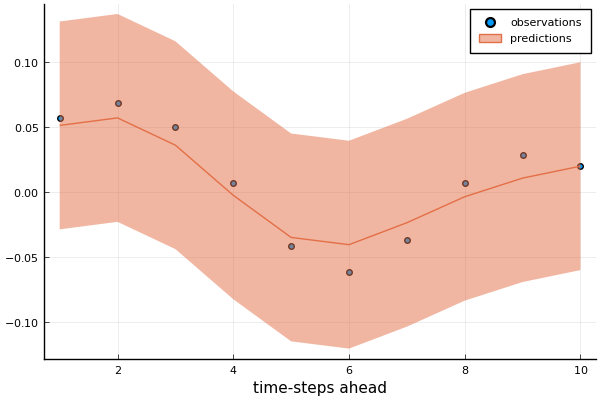

In [18]:
# Pick a time-point and visualize forecasting
t = 9000

# Mean and std dev of predictions
zpred_lar_mean = params_zpred_lar[1][1,t,2:TT+1]
zpred_lar_std = sqrt.(inv.(params_zpred_lar[2][1,1,t,2:TT+1])) 


scatter(output_[t+1:t+TT], label="observations", xlabel="time-steps ahead")
plot!(zpred_lar_mean, ribbon=[zpred_lar_std, zpred_lar_std], label="predictions")

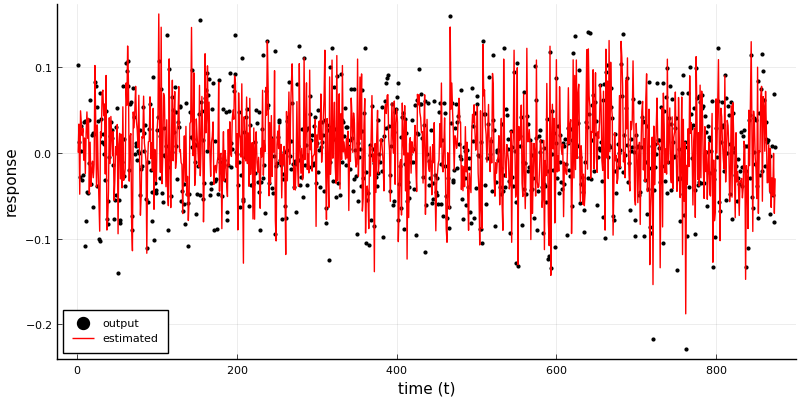

In [19]:
# Pick a number of steps ahead
tt = 2

# Extract mean of state marginals
estimated_states_lar = params_zpred_lar[1][1,:,tt]

# Plot every n-th time-point to avoid figure size exploding
n = 100

p23 = Plots.scatter(output_[1:n:end], color="black", label="output", markersize=2, size=(800,400), xlabel="time (t)", ylabel="response", legend=:bottomleft)
Plots.plot!(estimated_states_lar[1:n:end], color="red", linewidth=1, label="estimated")

In [20]:
Plots.savefig(p23, "viz/forecasted-states-lar_"*string(tt)*"stepahead.png")

## Baselines - random walk

In [32]:
# System identification graph
graph5 = FactorGraph()

# Static parameters
θ = [1.0, 0.0]
η = 1.0
γ = params_γ[1][end]./params_γ[2][end]
ξ = params_ξ[1][end]./params_ξ[2][end]

# Nonlinearity
function g(arg::Array{Float64,1}; num_coeffs::Int64=2)
    θ = arg[1:num_coeffs]
    x = arg[num_coeffs+1:end]
    return θ[1]*x[1] + θ[2]*x[2]
end

# State prior
@RV z_rw ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_t)

# Autoregressive node
@RV x_rw ~ NLatentAutoregressiveX(θ, z_rw, η, placeholder(:u_t), γ, g=g, id=:x_t)

# Specify likelihood
@RV y_t ~ GaussianMeanPrecision(dot([1. , 0.], x_rw), ξ, id=:y_t)

# Placeholder for observation
placeholder(y_t, :y_t)

# Draw time-slice subgraph
ForneyLab.draw(graph5)

# Inference algorithm
q5 = PosteriorFactorization(z_rw, x_rw, ids=[:z_rw, :x_rw])
algo5 = variationalAlgorithm(q5, free_energy=false)
source_code5 = algorithmSourceCode(algo5, free_energy=false)
eval(Meta.parse(source_code5));
# println(source_code5)

# Forecasting graph
graph6 = FactorGraph()

# State prior
@RV z_pred_rw ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_t)

# Autoregressive node
@RV x_pred_rw ~ NLatentAutoregressiveX(θ, z_pred_rw, η, placeholder(:u_t), γ, g=g, id=:x_t)

# Draw time-slice subgraph
ForneyLab.draw(graph6)

# Inference algorithm
q6 = PosteriorFactorization(z_pred_rw, x_pred_rw, ids=[:z_pred_rw, :x_pred_rw])
algo6 = variationalAlgorithm(q6, free_energy=false)
source_code6 = algorithmSourceCode(algo6, free_energy=false)
eval(Meta.parse(source_code6));
# println(source_code6)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 14385806237542931819 -->
 
 14385806237542931819 
 
 placeholder_u_t 
 
<!-- 2968495719389025564 -->
 
 2968495719389025564 
 
 clamp_3 
 
<!-- 9951621970487587494 -->
 
 9951621970487587494 
 
 placeholder_m_z 
 
<!-- 8876373069870102023 -->
 
 8876373069870102023 
 
 𝒩 
 y_t 
 
<!-- 9242576367690204038 -->
 
 9242576367690204038 
 
 dot 
 dotproduct_1 
 
<!-- 8876373069870102023--9242576367690204038 -->
 
 8876373069870102023--9242576367690204038 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 6833435796850690151 -->
 
 6833435796850690151 
 
 clamp_5 
 
<!-- 8876373069870102023--6833435796850690151 -->
 
 8876373069870102023--6833435796850690151 
 
 clamp_5 
 1 out 
 3 w 
 
<!-- 8169879981180155638 -->
 
 8169879981180155638 
 
 clamp_4 
 
<!-- 3419560736147671278 -->
 
 3419560736147671278 
 
 NLARX 
 x_t 
 
<!-- 3419560736147671278--14385806237542931819 -->
 
 3419560736147671278--14385806237542931819 
 
 u_t 
 1 out 
 5 u 
 
<!-- 3419560736147671278--2968495719389025564 -->
 
 3419560736147671278--2968495719389025564 
 
 clamp_3 
 1 out 
 6 γ 
 
<!-- 7160507224564806765 -->
 
 7160507224564806765 
 
 clamp_1 
 
<!-- 3419560736147671278--7160507224564806765 -->
 
 3419560736147671278--7160507224564806765 
 
 clamp_1 
 1 out 
 3 θ 
 
<!-- 14896255404329917919 -->
 
 14896255404329917919 
 
 𝒩 
 z_t 
 
<!-- 3419560736147671278--14896255404329917919 -->
 
 3419560736147671278--14896255404329917919 
 
 z_rw 
 1 out 
 2 x 
 
<!-- 453096508693320642 -->
 
 453096508693320642 
 
 clamp_2 
 
<!-- 3419560736147671278--453096508693320642 -->
 
 3419560736147671278--453096508693320642 
 
 clamp_2 
 1 out 
 4 η 
 
<!-- 9242576367690204038--8169879981180155638 -->
 
 9242576367690204038--8169879981180155638 
 
 clamp_4 
 1 out 
 3 in2 
 
<!-- 9242576367690204038--3419560736147671278 -->
 
 9242576367690204038--3419560736147671278 
 
 x_rw 
 1 y 
 2 in1 
 
<!-- 4519284992664031749 -->
 
 4519284992664031749 
 
 placeholder_y_t 
 
<!-- 4519284992664031749--8876373069870102023 -->
 
 4519284992664031749--8876373069870102023 
 
 y_t 
 1 out 
 1 out 
 
<!-- 16024828482172449555 -->
 
 16024828482172449555 
 
 placeholder_w_z 
 
<!-- 14896255404329917919--9951621970487587494 -->
 
 14896255404329917919--9951621970487587494 
 
 m_z 
 1 out 
 2 m 
 
<!-- 14896255404329917919--16024828482172449555 -->
 
 14896255404329917919--16024828482172449555 
 
 w_z 
 1 out 
 3 w

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 12404086378944378583 -->
 
 12404086378944378583 
 
 clamp_3 
 
<!-- 11891499091538190779 -->
 
 11891499091538190779 
 
 placeholder_m_z 
 
<!-- 15014847066968578195 -->
 
 15014847066968578195 
 
 NLARX 
 x_t 
 
<!-- 15014847066968578195--12404086378944378583 -->
 
 15014847066968578195--12404086378944378583 
 
 clamp_3 
 1 out 
 6 γ 
 
<!-- 8995797199667628825 -->
 
 8995797199667628825 
 
 clamp_1 
 
<!-- 15014847066968578195--8995797199667628825 -->
 
 15014847066968578195--8995797199667628825 
 
 clamp_1 
 1 out 
 3 θ 
 
<!-- 5379763546710544360 -->
 
 5379763546710544360 
 
 placeholder_u_t 
 
<!-- 15014847066968578195--5379763546710544360 -->
 
 15014847066968578195--5379763546710544360 
 
 u_t 
 1 out 
 5 u 
 
<!-- 11641352342754955370 -->
 
 11641352342754955370 
 
 clamp_2 
 
<!-- 15014847066968578195--11641352342754955370 -->
 
 15014847066968578195--11641352342754955370 
 
 clamp_2 
 1 out 
 4 η 
 
<!-- 9251082436589114037 -->
 
 9251082436589114037 
 
 𝒩 
 z_t 
 
<!-- 15014847066968578195--9251082436589114037 -->
 
 15014847066968578195--9251082436589114037 
 
 z_pred_rw 
 1 out 
 2 x 
 
<!-- 13227349994854903986 -->
 
 13227349994854903986 
 
 placeholder_w_z 
 
<!-- 9251082436589114037--11891499091538190779 -->
 
 9251082436589114037--11891499091538190779 
 
 m_z 
 1 out 
 2 m 
 
<!-- 9251082436589114037--13227349994854903986 -->
 
 9251082436589114037--13227349994854903986 
 
 w_z 
 1 out 
 3 w 
 
<!-- 98663296021625808362 -->
 
 98663296021625808362 
 
<!-- 98663296021625808362--15014847066968578195 -->
 
 98663296021625808362--15014847066968578195 
 
 x_pred_rw 
 1 y

In [33]:
# Number of steps ahead
TT = 10

# Inference parameters
num_iterations = 4

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_z = (zeros(2,T_ - TT), repeat(.1 .*float(eye(2)), outer=(1,1,T_ - TT)))

# Initialize future state arrays
params_zpred_rw = (zeros(2, T_ - TT, TT+1), repeat(.1 .*float(eye(2)), outer=(1,1,T_ - TT, TT+1)))
pred_diff_rw = zeros(T_ - TT, TT)
pred_pwerr_rw = zeros(T_ - TT, TT)

# Start progress bar
p = Progress(T_ - TT, 1, "At time ")

# Perform inference at each time-step
for t = 2:(T_ - TT)

    # Update progress bar
    update!(p, t)
    
    "Filtering"

    # Initialize marginals
    marginals[:x_rw] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_z[1][:,t-1], w=params_z[2][:,:,t-1])
    marginals[:z_rw] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_z[1][:,t-1], w=params_z[2][:,:,t-1])
    
    data = Dict(:y_t => output_[t],
                :u_t => input_[t],
                :m_z => params_z[1][:,t-1],
                :w_z => params_z[2][:,:,t-1])

    # Iterate variational parameter updates
    for i = 1:num_iterations

        stepx_rw!(data, marginals)
    #         stepz!(data, marginals)
    end

    # Store current parameterizations of marginals
    params_z[1][:,t] = unsafeMean(marginals[:x_rw])
    params_z[2][:,:,t] = marginals[:x_rw].params[:w]
    
    "Forecast several steps ahead"
    
    if T_ > 2
    
        params_zpred_rw[1][:,t,1] = params_z[1][:,t]
        params_zpred_rw[2][:,:,t,1] = params_z[2][:,:,t]

        for tt = 1:TT

            # Initialize marginals
            marginals[:x_pred_rw] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_zpred_rw[1][:,t,tt], w=params_zpred_rw[2][:,:,t,tt])
            marginals[:z_pred_rw] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_zpred_rw[1][:,t,tt], w=params_zpred_rw[2][:,:,t,tt])

            data = Dict(:u_t => input_[t+tt],
                        :m_z => params_zpred_rw[1][:,t,tt],
                        :w_z => params_zpred_rw[2][:,:,t,tt])

            # Iterate variational parameter updates
            for i = 1:num_iterations
                stepx_pred_rw!(data, marginals)
        #             stepz_pred!(data, marginals)
            end

            # Store current parameterizations of marginals
            params_zpred_rw[1][:,t,tt+1] = unsafeMean(marginals[:x_pred_rw])
            params_zpred_rw[2][:,:,t,tt+1] = marginals[:x_pred_rw].params[:w]

        end

        # Evaluate prediction error for forecast
        pred_diff_rw[t,:] = (params_zpred_rw[1][1,t,2:end] .- output_[t+1:t+TT])
        pred_pwerr_rw[t,:] = params_zpred_rw[2][1,1,t,2:end].*(params_zpred_rw[1][1,t,2:end] .- output_[t+1:t+TT]).^2

    end

end

At time 100%|███████████████████████████████████████████| Time: 0:01:32


## Visualize forecasting results

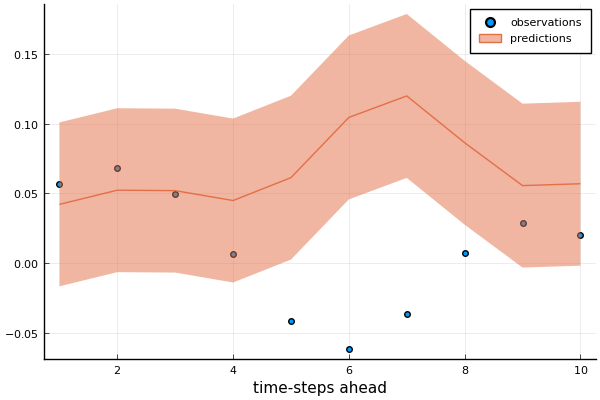

In [34]:
# Pick a time-point and visualize forecasting
t = 9000

# Mean and std dev of predictions
zpred_rw_mean = params_zpred_rw[1][1,t,2:TT+1]
zpred_rw_std = sqrt.(inv.(params_zpred_rw[2][1,1,t,2:TT+1])) 


scatter(output_[t+1:t+TT], label="observations", xlabel="time-steps ahead")
plot!(zpred_rw_mean, ribbon=[zpred_rw_std, zpred_rw_std], label="predictions")

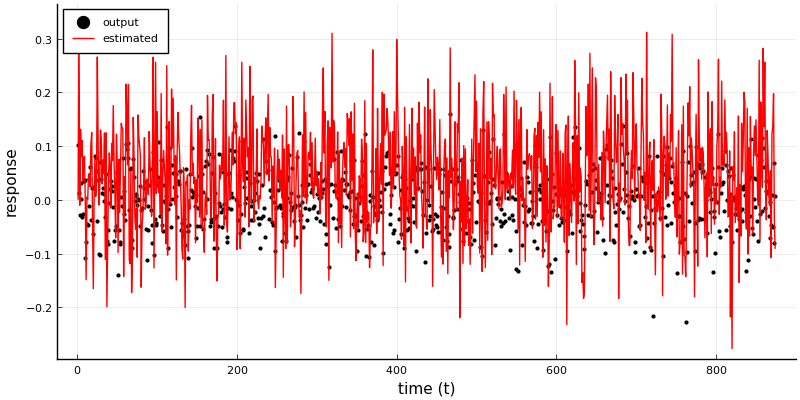

In [35]:
# Extract mean of state marginals
estimated_states_rw = params_zpred_rw[1][1,:,9]

# Plot every n-th time-point to avoid figure size exploding
n = 100

p3 = Plots.scatter(output_[1:n:end], color="black", label="output", markersize=2, size=(800,400), xlabel="time (t)", ylabel="response", legend=:topleft)
Plots.plot!(estimated_states_rw[1:n:end], color="red", linewidth=1, label="estimated")

## Visualize performance results

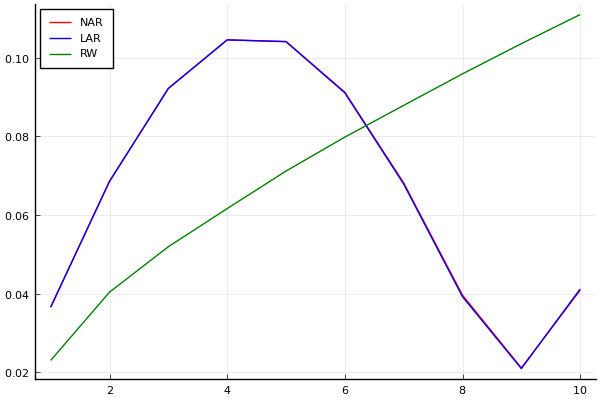

In [36]:
RMSE_rw = zeros(TT,)
RMSE_lar = zeros(TT,)
RMSE_nar = zeros(TT,)

ix = 20000:67390

for tt = 1:TT

    # Compute RMSE for each step ahead
    RMSE_rw[tt] = sqrt.(mean((params_zpred_rw[1][1,ix,1+tt] .- output_[ix]).^2))
    RMSE_lar[tt] = sqrt.(mean((params_zpred_lar[1][1,ix,1+tt] .- output_[ix]).^2))
    RMSE_nar[tt] = sqrt.(mean((params_zpred_nar[1][1,ix,1+tt] .- output_[ix]).^2))
    
end

p110 = plot(1:TT, RMSE_nar, color="red", label="NAR", size=(600,400))
plot!(1:TT, RMSE_lar, color="blue", label="LAR", size=(600,400))
plot!(1:TT, RMSE_rw, color="green", label="RW", size=(600,400))

In [37]:
savefig(p110, "viz/RMSE_comparison.png")

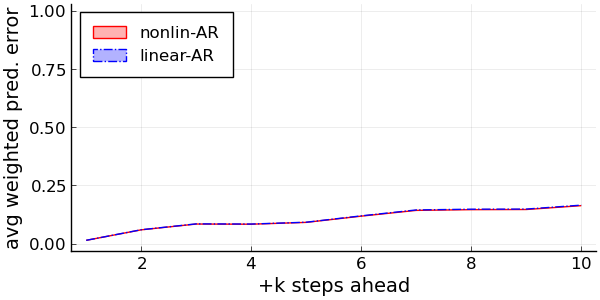

In [38]:
ix = 10:87390

mpwerr_lar = mean(pred_pwerr_lar[ix,:], dims=1)' 
spwerr_lar = sqrt.(var(pred_pwerr_lar[ix,:], dims=1)') ./length(ix)
mpwerr_nar = mean(pred_pwerr_nar[ix,:], dims=1)' 
spwerr_nar = sqrt.(var(pred_pwerr_nar[ix,:], dims=1)') ./ length(ix)

# p110 = plot(1:TT, mpwerr_nar, color="red", label="nonlin-AR")
p110 = plot(1:TT, mpwerr_nar, ribbon=[spwerr_nar, spwerr_nar], fillalpha=0.3, color="red", label="nonlin-AR")
# plot!(1:TT, mpwerr_lar, color="blue", label="linear-AR", linestyle=:dashdot)
plot!(1:TT, mpwerr_lar, ribbon=[spwerr_lar, spwerr_lar], fillalpha=0.3, label="linear-AR", linestyle=:dashdot, color="blue", size=(600,300), ylim=[0., 1.], legend=:topleft, tickfontsize=12, xlabel="+k steps ahead", ylabel="avg weighted pred. error", legendfontsize=12, guidefontsize=14)
# plot!(1:TT, mpwerr_rw, color="green", label="RW", size=(600,400), ylim=[0., 1.], legend=:topleft)

In [39]:
savefig(p110, "viz/mpwerr_comparison.png")
savefig(p110, "viz/mpwerr_comparison.pdf")

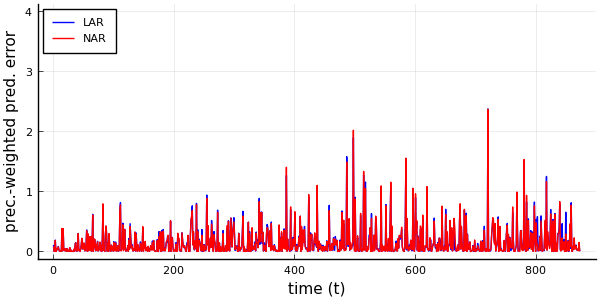

In [40]:
# Select subsampling
ss = 100

# Select a number of time-steps ahead
tt = 10

# Index performance metrics
pwerr_rw_tt = pred_pwerr_rw[10:ss:end,tt]
pwerr_lar_tt = pred_pwerr_lar[10:ss:end,tt]
pwerr_nar_tt = pred_pwerr_nar[10:ss:end,tt]

# Plot mean difference for all time
# plot(pwerr_rw_tt, color="green", label="RW", markersize=2, size=(600,400), xlabel="time (t)", ylabel="precision-weighted prediction error")
plot(pwerr_lar_tt, color="blue", label="LAR", markersize=2, size=(600,300), xlabel="time (t)", ylabel="prec.-weighted pred. error")
plot!(pwerr_nar_tt, color="red", label="NAR", markersize=2, size=(600,300), ylim=[0., 4.], legend=:topleft)

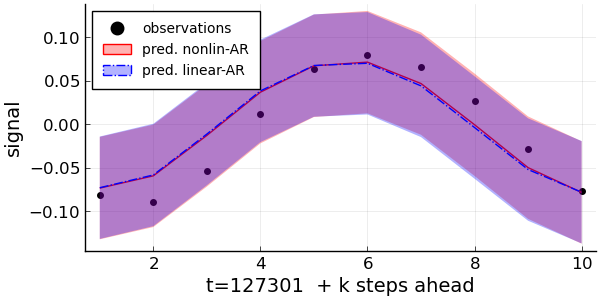

In [41]:
# Pick a time-point and visualize forecasting
t = 87200

xticks = [string(t)*"+1", string(t)*"+2"]

# Mean and std dev of predictions
zpred_nar_mean = params_zpred_nar[1][1,t,2:TT+1]
zpred_nar_std = sqrt.(inv.(params_zpred_nar[2][1,1,t,2:TT+1])) 
zpred_lar_mean = params_zpred_lar[1][1,t,2:TT+1]
zpred_lar_std = sqrt.(inv.(params_zpred_lar[2][1,1,t,2:TT+1])) 


p224 = scatter(output_[t+1:t+TT], label="observations", color="black", xlabel="t="*string(t+40101)*"  + k steps ahead")
plot!(zpred_nar_mean, ribbon=[zpred_nar_std, zpred_nar_std], fillalpha=0.3, color="red", label="pred. nonlin-AR")
plot!(zpred_lar_mean, ribbon=[zpred_lar_std, zpred_lar_std], fillalpha=0.3, color="blue", linestyle=:dashdot, label="pred. linear-AR", size=(600,300), tickfontsize=12, legendfontsize=10, legend=:topleft, ylabel="signal", guidefontsize=14)

In [42]:
savefig(p224, "viz/example-forecast-comparison.png")
savefig(p224, "viz/example-forecast-comparison.pdf")